# Imports

In [4]:
# import stuff
import os, sys, time, json, csv, math, difflib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile as tif
from scipy.ndimage.interpolation import zoom

In [5]:
import warnings
warnings.simplefilter('ignore')

# User Inputs

In [8]:
# load label csvs 
labels_dir = '/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/'
#lab_sigma = pd.read_csv(os.path.join(labels_dir,'SIGMA_labels.csv'))
#lab_whs = pd.read_csv(os.path.join(labels_dir,'WHS_labels.csv'))
#lab_schwarz = pd.read_csv(os.path.join(labels_dir,'schwarz_rl_annotations.csv'))
lab_pma = pd.read_csv('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/PMA_anns.csv')
#lab_chon = pd.read_csv(os.path.join(labels_dir,'chon_full.csv'))

# load helper files
syns = pd.read_csv(os.path.join(labels_dir,'syns_with_parents.csv'))
PRAlabs = pd.read_csv(os.path.join(labels_dir,'PRA_labels.csv'))

# load json
with open(os.path.join(labels_dir,'PRA_ontology.json')) as f:
  ontology = json.load(f)

In [9]:
ontology

{'id': 0,
 'common_name': 'root',
 'graph_order': 0,
 'parent_structure_id': None,
 'children': [{'id': 4,
   'name': 'grooves',
   'parent_id': 0,
   'graph_order': 1,
   'children': []},
  {'id': 112,
   'name': 'cerebral_peduncles',
   'parent_id': 0,
   'graph_order': 1,
   'children': []},
  {'id': 452,
   'name': 'clear_label',
   'parent_id': 0,
   'graph_order': 1,
   'children': []},
  {'id': 6,
   'name': 'cochlea',
   'parent_id': 0,
   'graph_order': 1,
   'children': []},
  {'id': 2,
   'name': 'fiber_tracts',
   'parent_id': 0,
   'graph_order': 1,
   'children': [{'id': 156,
     'name': 'cerebellar_fiber_tracts',
     'parent_id': 2,
     'graph_order': 2,
     'children': []},
    {'id': 569,
     'name': 'cerebellum_related_fiber_tracts',
     'parent_id': 2,
     'graph_order': 2,
     'children': [{'id': 430,
       'name': 'fornix',
       'parent_id': 569,
       'graph_order': 3,
       'children': []},
      {'id': 154,
       'name': 'medial_lemniscus_decussati

# Define Functions

In [4]:
def reformat(str_in):
    if isinstance(str_in,str):
        if str_in[-1]== ' ':
            str_in = str_in[:-1]
        str_in = str_in.replace(" ","_")
        str_in = str_in.replace("/","_")
        str_in = str_in.replace(",","")
        str_out = str_in.lower()
        
        str_out = str_out.replace("_left","")
        str_out = str_out.replace("_right","")
        str_out = str_out.replace("left","")
        str_out = str_out.replace("right","")
    else:
        print('{} is not a string'.format(str_in))
    return str_out

In [5]:
def replace_with_common_name(pd_in,syns):
    pd_out = pd_in.copy()
    for i in np.arange(0,len(pd_out.name)):
        lab = pd_out.name[i]
        if isinstance(lab,str):
            lab = reformat(lab)
            if (syns.name == lab).any(): 
                pd_out.name[i]=check_for_syn(lab,syns)
    return pd_out

In [6]:
def check_for_syn(name,syns):
    if name in list(syns.name):
        synonymns = syns[syns.name==name]['common_name']
    else: 
        synonymns=[]
    return synonymns

In [7]:
# get the parent name of a given name/volume
def get_parent_id_from_praid(labeledvolume,praid):
    parentid=list(labeledvolume.loc[labeledvolume.id == praid,'parent_id'])[0]
    return parentid

In [8]:
# get the hierarchy/family tree of a given name in a given volume
def get_hierarchy(labeledvolume,praid,maxlen):
    familytree = []
    parentid = get_parent_id_from_praid(labeledvolume,praid)
    # if parent isn't root, look for grandparent
    while parentid > 0:
        # add parent/grandparent... to tree
        familytree.append(parentid)
        # get grandparent/great grandparent...
        parentid=get_parent_id_from_praid(labeledvolume,parentid)
    familytree.reverse()
    print('family tree was {}'.format(familytree))
    if len(familytree) < 1:
        familytree=0
    return familytree   

In [9]:
# get all dissimilarity values for each overlapping set in two labeled volumes
def get_dissimilarity(Alab,Aval,Blab,Bval):
    nameA = get_name(Alab,Aval)
    print(nameA)
    familytreeA = get_hierarchy(Alab,nameA)
    nameB = get_name(Blab,Bval)
    print(nameB)
    familytreeB = get_hierarchy(Blab,nameB)
    if len(familytreeA) > len(familytreeB):
        # if family tree A longer than B
        diss = get_diss_value(familytreeA,familytreeB)
    elif len(familytreeB) > len(familytreeA):
        diss = get_diss_value(familytreeB,familytreeA)
    else:
        da = get_diss_value(familytreeA,familytreeB)
        db = get_diss_value(familytreeB,familytreeA)
        diss = min(da,db)
    return diss


# if you need to make a PRAlabs-like dataframe from a json file, extracting the group levels

In [10]:
!pip install pandas update

  Using cached update-0.0.1-py2.py3-none-any.whl (2.9 kB)
  Using cached style-1.1.0-py2.py3-none-any.whl (6.4 kB)


In [20]:
tst = pd.io.json.json_normalize(data=ontology['name'])

In [100]:
# get children, parents for json entries
data = pd.io.json.json_normalize(data=ontology['children'])
data.insert(5,'has_children',0)
for i in data.index:
    print('i is {}'.format(i))
    if len(data.children[i])>0:
        data.has_children[i]=1
        contents=[]
        for j in np.arange(0,len(data.children[i])):
            #print('j is {}'.format(j))
            contents.append(data.children[i][j]['id'])
        data.at[i,'children']=contents
new = data
val = 0

while len(new) > 0:
    val+=1
    new=pd.io.json.json_normalize(data=ontology['children'],record_path=np.repeat('children',val).tolist())
    if len(new)>0:
        new.insert(5,'has_children',0)
        for i in new.index:
            if len(new.children[i])>0:
                new.has_children[i]=1
                contents=[]
                for j in np.arange(0,len(new.children[i])):
                    contents.append(new.children[i][j]['id'])
                #print(i)
                new.at[i,'children']=contents
    data = pd.concat([data,new])   
data=data.reset_index()

data.insert(6,'parent_ids',0)
for i in np.arange(0,max(data.graph_order)+1):
    go = max(data.graph_order)-i
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~ go is {}'.format(go))
    for j in data.index[data.graph_order==go]:
        curr_children = data.children[j]
        for k in data.children[j]:
            if len(data.children[data.id==k]) > 0: 
                curr_children = curr_children + list(data.children[data.id==k])[0]
        data.at[j,'children']=curr_children
        #print('j {} ends as {}'.format(j,curr_children))

i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
i is 6
i is 7
i is 8
i is 9
i is 10
i is 11
i is 12
i is 13
i is 14
~~~~~~~~~~~~~~~~~~~~~~~~~~ go is 6
~~~~~~~~~~~~~~~~~~~~~~~~~~ go is 5
~~~~~~~~~~~~~~~~~~~~~~~~~~ go is 4
~~~~~~~~~~~~~~~~~~~~~~~~~~ go is 3
~~~~~~~~~~~~~~~~~~~~~~~~~~ go is 2
~~~~~~~~~~~~~~~~~~~~~~~~~~ go is 1
~~~~~~~~~~~~~~~~~~~~~~~~~~ go is 0


In [102]:
data = data.drop(columns='index')


In [104]:
data

,id,name,parent_id,graph_order,children,parent_ids,has_children
0,35,brainstem,0,1,"[39, 40, 41, 577, 595, 189, 190, 265, 266, 267...",0,1
1,36,cerebellum,0,1,"[43, 51, 52, 53, 54, 55, 127, 128, 129, 184, 1...",0,1
2,37,cerebrum,0,1,"[59, 63, 64, 65, 66, 67, 398, 564, 565, 567, 5...",0,1
3,243,corpus_collosum,0,1,[],0,0
4,244,corticospinal_tract,0,1,"[112, 113, 114, 115]",0,1
...,...,...,...,...,...,...,...
612,475,accumbens_nucleus,607,6,[],0,0
613,476,olfactory_tubercle,607,6,[],0,0
614,477,striatum_fundus,607,6,[],0,0
615,132,cuneate_fascicle,74,6,[],0,0


In [186]:
data=pd.read_csv('/Users/emilydennis/Desktop/pra_update.csv')

In [187]:
data.insert(3,'parent_ids','')

In [188]:
data.parent_ids=data.parent_ids.astype('object')

In [189]:
data.parent_id[data.index[data.id == data.parent_id[15]][0]]

189

In [190]:
data

,id,name,parent_id,parent_ids
0,1000,basic_cell_groups_and_regions,0,
1,35,brainstem,1000,
2,39,hindbrain,35,
3,189,medulla,39,
4,265,spinal_trigeminal_nucleus,189,
...,...,...,...,...
611,50,middle_cerebellar_peduncle,58,
612,603,postcommissural_fornix,450,
613,430,fornix,603,
614,3000,clear_label,0,


In [191]:
for idx in data.index:
    pids=[data.id[idx]]
    index=idx
    #print(idx)
    while index < 100000000:
        if data.parent_id[index] == 0:
            pids.append(0)
            #print(pids)
            data.at[idx,'parent_ids'] = pids
            index=1000000000
        else:
            #print('in while, idx is {} index is {}'.format(idx,index))
            pids.append(data.parent_id[index])
            index = data.index[data.id == data.parent_id[index]][0]

In [192]:
data.insert(3,'new_parent_ids',data.parent_ids)

In [193]:
data

,id,name,parent_id,new_parent_ids,parent_ids
0,1000,basic_cell_groups_and_regions,0,"[1000, 0]","[1000, 0]"
1,35,brainstem,1000,"[35, 1000, 0]","[35, 1000, 0]"
2,39,hindbrain,35,"[39, 35, 1000, 0]","[39, 35, 1000, 0]"
3,189,medulla,39,"[189, 39, 35, 1000, 0]","[189, 39, 35, 1000, 0]"
4,265,spinal_trigeminal_nucleus,189,"[265, 189, 39, 35, 1000, 0]","[265, 189, 39, 35, 1000, 0]"
...,...,...,...,...,...
611,50,middle_cerebellar_peduncle,58,"[50, 58, 569, 450, 1000, 0]","[50, 58, 569, 450, 1000, 0]"
612,603,postcommissural_fornix,450,"[603, 450, 1000, 0]","[603, 450, 1000, 0]"
613,430,fornix,603,"[430, 603, 450, 1000, 0]","[430, 603, 450, 1000, 0]"
614,3000,clear_label,0,"[3000, 0]","[3000, 0]"


In [194]:
def make_bg_str(x):
    s=str(x[-1])
    for i in np.arange(2,len(x)+1):
        s = s+'/'+str(x[-i])
    return(s)

In [195]:
for idx in data.index:
    data.new_parent_ids[idx] = make_bg_str(data.parent_ids[idx])

In [196]:
data.to_csv('/Users/emilydennis/Desktop/pra.csv')

In [256]:
data['alt_parent_ids']=data['parent_ids']

In [223]:
idx=10
pids = data.parent_ids[idx].copy()
pids.reverse()
print(pids)

[270, 589, 189, 39, 35, 1000, 0]


In [254]:
def get_string_from_pids(pids):
    for i in np.arange(0,len(pids)):
        print("i is {}".format(i))
        if i == 0:
            s=str(pids[i])
        if pids[i] not in test[i]:
            test[i].append(pids[i])
        s=s+'.'+str(test[i].index(pids[i]))
    return s

In [231]:
pid_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}

In [257]:
for idx in data.index:
    pids = data.parent_ids[idx].copy()
    pids.reverse()
    s=get_string_from_pids(pids)
    data.alt_parent_ids[idx]=s
    print(idx)

i is 0
i is 1
0
i is 0
i is 1
i is 2
1
i is 0
i is 1
i is 2
i is 3
2
i is 0
i is 1
i is 2
i is 3
i is 4
3
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
4
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
5
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
6
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
7
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
i is 6
8
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
i is 6
9
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
i is 6
10
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
i is 6
11
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
12
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
i is 6
13
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
i is 6
14
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
i is 6
15
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
i is 6
16
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
i is 6
17
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
i is 6
18
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
i is 6
19
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
i is 6
20
i is 0
i is 1
i is 2
i is 3
i is 4
i is 5
i is 6
21

In [260]:
data.to_csv('/Users/emilydennis/Desktop/pra_for_use.csv')

In [103]:
data

,id,name,parent_id,graph_order,children,parent_ids,has_children
0,35,brainstem,0,1,"[39, 40, 41, 577, 595, 189, 190, 265, 266, 267...",0,1
1,36,cerebellum,0,1,"[43, 51, 52, 53, 54, 55, 127, 128, 129, 184, 1...",0,1
2,37,cerebrum,0,1,"[59, 63, 64, 65, 66, 67, 398, 564, 565, 567, 5...",0,1
3,243,corpus_collosum,0,1,[],0,0
4,244,corticospinal_tract,0,1,"[112, 113, 114, 115]",0,1
...,...,...,...,...,...,...,...
612,475,accumbens_nucleus,607,6,[],0,0
613,476,olfactory_tubercle,607,6,[],0,0
614,477,striatum_fundus,607,6,[],0,0
615,132,cuneate_fascicle,74,6,[],0,0


# Example of how to take a labeled volume and relate to PRA

In [38]:
lab_atl = lab_pma.copy()[['name', 'id']]
lab_atl.columns=['label','ID']

In [39]:
lab_atl.insert(2,'common_name','null')
lab_atl.insert(2,'name','null')
lab_atl

,label,ID,name,common_name
0,"Tuberomammillary nucleus, ventral part",1,null,null
1,"Primary somatosensory area, mouth, layer 6b",2,null,null
2,secondary fissure,3,null,null
3,Inferior colliculus,4,null,null
4,internal capsule,6,null,null
...,...,...,...,...
1325,"Interpeduncular nucleus, intermediate",607344850,null,null
1326,"Interpeduncular nucleus, dorsomedial",607344854,null,null
1327,"Interpeduncular nucleus, dorsolateral",607344858,null,null
1328,"Interpeduncular nucleus, rostrolateral",607344862,null,null


In [40]:
syns.tail()

,common_name,name,parent
3056,raphe_nuclei,raphe,NaN
3057,thalamus_lateral_group,thalamus_dorsolateral,NaN
3058,thalamus_dorsal_nucleus,thalamus_midlinedorsal,NaN
3059,thalamus_ventromedial_nucleus,thalamus_ventromedial,NaN
3060,tegmental_nucleus_ventral,ventral_tegmentalarea,NaN


In [46]:
manual_check=[]
for i in lab_atl.index:
    lab_atl.at[i,'name']=reformat(lab_atl.label[i])
    nm=lab_atl.at[i,'name']
    if nm in list(syns.common_name):
        #print('if')
        lab_atl.at[i,'common_name']=nm
    elif nm in list(syns.name):
        #print('elif')
        lab_atl.at[i,'common_name']=list(syns.common_name[syns.name==nm])[0]
    else:
        manual_check.append(i)

In [47]:
manual_check

[]

In [48]:
# for each element of manual_check, we print the name, and closest options
# add to syns csv, and re-import!
for idval in manual_check:
    print(list(lab_atl[lab_atl.index==idval]['name'])[0])
    print(difflib.get_close_matches(list(lab_atl[lab_atl.index==idval]['name'])[0],list(PRAlabs.name),n=20,cutoff=0.1))

In [54]:
ontology.keys()

dict_keys(['name', 'praid', 'id', 'structure_id_path', 'parent_structure_id', 'acronym'])

In [90]:
PRAlabs

,Unnamed: 0,id,name,parent_id,graph_order,children,has_children,parent_ids
0,0,35,brainstem,0,1,"[39, 40, 41, 577, 595, 189, 190, 265, 266, 267...",1,0
1,1,36,cerebellum,0,1,"[43, 51, 52, 53, 54, 55, 127, 128, 129, 184, 1...",1,0
2,2,37,cerebrum,0,1,"[59, 63, 64, 65, 66, 67, 398, 564, 565, 567, 5...",1,0
3,3,243,corpus_collosum,0,1,[],0,0
4,4,244,corticospinal_tract,0,1,"[112, 113, 114, 115]",1,0
...,...,...,...,...,...,...,...,...
612,612,475,accumbens_nucleus,607,6,[],0,"[37, 66, 34, 61, 607]"
613,613,476,olfactory_tubercle,607,6,[],0,"[37, 66, 34, 61, 607]"
614,614,477,striatum_fundus,607,6,[],0,"[37, 66, 34, 61, 607]"
615,615,132,cuneate_fascicle,74,6,[],0,"[450, 157, 116, 136, 74]"


In [60]:
type(PRAlabs['alt_parent_ids'][0])

str

In [61]:
# great! now we have common_names that match our PRA ID info. 
# Merge that info into your volume labels.
lab_atl=lab_atl.assign(praid=0,structure_id_path='0',alt_parent_ids='0.0')
lab_atl

,label,ID,name,common_name,praid,structure_id_path,alt_parent_ids
0,"Tuberomammillary nucleus, ventral part",1,tuberomammillary_nucleus_ventral_part,hypothalamus_tuberomammillary_nucleus,0,0,0.0
1,"Primary somatosensory area, mouth, layer 6b",2,primary_somatosensory_area_mouth_layer_6b,primary_somatosensory_cortex,0,0,0.0
2,secondary fissure,3,secondary_fissure,secondary_fissure,0,0,0.0
3,Inferior colliculus,4,inferior_colliculus,inferior_colliculus,0,0,0.0
4,internal capsule,6,internal_capsule,internal_capsule,0,0,0.0
...,...,...,...,...,...,...,...
1325,"Interpeduncular nucleus, intermediate",607344850,interpeduncular_nucleus_intermediate,interpeduncular_nucleus,0,0,0.0
1326,"Interpeduncular nucleus, dorsomedial",607344854,interpeduncular_nucleus_dorsomedial,interpeduncular_nucleus,0,0,0.0
1327,"Interpeduncular nucleus, dorsolateral",607344858,interpeduncular_nucleus_dorsolateral,interpeduncular_nucleus,0,0,0.0
1328,"Interpeduncular nucleus, rostrolateral",607344862,interpeduncular_nucleus_rostrolateral,interpeduncular_nucleus,0,0,0.0


In [154]:
PRAlabs = pd.read_csv('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/PRA_labels.csv')

In [155]:
syns = pd.read_csv('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/syns_with_parents.csv')

In [156]:
syns

,common_name,name,parent
0,abducens_nucleus,abducens_nucleus,medulla_motor_related
1,accumbens_nucleus,accumbens_core,NaN
2,accumbens_nucleus,accumbens_nucleus,striatum_ventral_region
3,accumbens_nucleus,accumbens_shell,NaN
4,accumbens_nucleus,accumbensshell,NaN
...,...,...,...
3419,visual_cortex,visual_cortex,cortex
3420,vomeronasal_nerve,vomeronasal_nerve,cranial_nerves
3421,NaN,NaN,NaN
3422,NaN,NaN,NaN


In [157]:
'forebrain_bundle_system_lateral' in x.tolist()

True

In [158]:
x=PRAlabs.name
fix = []
for name in syns.common_name:
    if name not in x.tolist():
        print(name)
        fix.append(name)

nan
nan
nan


In [107]:
unique = pd.read_csv('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/unique_names_withid.csv')

In [125]:
manual_check=[]
for i in lab_atl.index:
    atl_nm = lab_atl.common_name[i]
    df = PRAlabs[PRAlabs.name==lab_atl.common_name[i]].reset_index()
    if len(df)==0:
        manual_check.append(i)
    else:
        lab_atl.praid[i]=df.id.values[0]
        lab_atl.structure_id_path[i]=df.at[0,'structure_id_path']
        lab_atl.alt_parent_ids[i]=df.at[0,'alt_parent_ids']



KeyError: 'structure_id_path'

In [74]:
i=0
lab_atl.common_name[i]
#df = PRAlabs[PRAlabs.name==]
lab_atl.common_name[i] in ontology['name']

False

In [63]:
manual_check#if you updated syns but there are still issues...
# make sure you re-ran user inputs cell, to do so, uncomment below
# then re-run first manual_check loop
#syns = pd.read_csv(os.path.join(labels_dir,'syns_with_parents.csv'))


[0,
 2,
 3,
 4,
 5,
 6,
 9,
 10,
 11,
 12,
 13,
 15,
 16,
 18,
 20,
 21,
 23,
 25,
 26,
 29,
 30,
 32,
 33,
 34,
 35,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 64,
 65,
 66,
 68,
 69,
 70,
 71,
 73,
 74,
 75,
 76,
 77,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 87,
 88,
 90,
 92,
 93,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 108,
 109,
 110,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 127,
 128,
 129,
 130,
 131,
 132,
 134,
 136,
 137,
 138,
 139,
 140,
 141,
 143,
 144,
 146,
 147,
 148,
 149,
 151,
 153,
 154,
 155,
 156,
 157,
 159,
 160,
 161,
 162,
 163,
 164,
 166,
 167,
 168,
 169,
 170,
 171,
 173,
 174,
 175,
 177,
 178,
 181,
 183,
 184,
 185,
 186,
 189,
 190,
 191,
 192,
 194,
 195,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 221,
 222,
 223,
 224,
 225,

In [92]:
syns

,common_name,name,parent
0,abducens_nucleus,abducens_nucleus,medulla_motor_related
1,accumbens_nucleus,accumbens_core,NaN
2,accumbens_nucleus,accumbens_nucleus,striatum_ventral_region
3,accumbens_nucleus,accumbens_shell,NaN
4,accumbens_nucleus,accumbensshell,NaN
...,...,...,...
3416,cranial_nerves,terminal_nerve,NaN
3417,corticospinal_tract,thalamic_peduncles,NaN
3418,inferior_cerebellar_peduncle,trigeminocerebellar_tract,NaN
3419,cervicothalamic_tract,ventral_commissure_of_the_spinal_cord,NaN


In [96]:
PRAlabs

,Unnamed: 0,id,name,parent_id,graph_order,children,has_children,parent_ids
0,0,35,brainstem,0,1,"[39, 40, 41, 577, 595, 189, 190, 265, 266, 267...",1,0
1,1,36,cerebellum,0,1,"[43, 51, 52, 53, 54, 55, 127, 128, 129, 184, 1...",1,0
2,2,37,cerebrum,0,1,"[59, 63, 64, 65, 66, 67, 398, 564, 565, 567, 5...",1,0
3,3,243,corpus_collosum,0,1,[],0,0
4,4,244,corticospinal_tract,0,1,"[112, 113, 114, 115]",1,0
...,...,...,...,...,...,...,...,...
612,612,475,accumbens_nucleus,607,6,[],0,"[37, 66, 34, 61, 607]"
613,613,476,olfactory_tubercle,607,6,[],0,"[37, 66, 34, 61, 607]"
614,614,477,striatum_fundus,607,6,[],0,"[37, 66, 34, 61, 607]"
615,615,132,cuneate_fascicle,74,6,[],0,"[450, 157, 116, 136, 74]"


In [319]:
lab_atl.to_csv('/Users/emilydennis/Desktop/sigma_202107.csv')

In [322]:
lab_atl.to_json('/Users/emilydennis/Desktop/sigma_202107.json')

In [312]:
lab_atl = lab_atl.rename(columns={"structureOrder":'struct_order'})

In [324]:
labtst = lab_atl.copy()
labtst=labtst.drop(columns=['atlas','common_name','ID','alt_parent_ids','label','parent_ids'])

In [337]:
labtst['id'] = labtst.praid
labtst['structure_id_path']=labtst.new_parent_ids
labtst['parent_structure_id'] = labtst.parent_id

In [346]:
labtst=labtst.drop(columns=['praid'])

In [379]:
x='test'
y=2
type(y)

int

In [363]:
dftest = labtst.drop_duplicates(ignore_index=True)

In [380]:
lab_dict=[]
for i in dftest.index:
    lab_dict.append({"name": dftest.name[i],"acronym":dftest.acronym[i],"id":dftest.id[i].item(),"structure_id_path":dftest.structure_id_path[i]})
    

In [384]:
with open('/Users/emilydennis/Desktop/test.json', 'w') as fout:
    json.dump(lab_dict,fout)

In [315]:
manual_check=[]
for i in PRAlabs.index:
    #miprint(i)
    atl_nm = PRAlabs.name[i]
    df = lab_atl[lab_atl.common_name==PRAlabs.name[i]].reset_index()
    if len(df)==0:
        manual_check.append(i)
    else:
        PRAlabs.struct_order[i] = df.struct_order[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [432]:
colors = [[255,255,255],[140,78,153],[111,76,155],[96,89,169],[85,104,184],[78,121,197],[77,138,198],[78,150,188],[84,158,179],[89,165,169],[96,171,158],[105,177,144],[119,183,125],[140,188,104],[166,190,84],[190,188,72],[209,181,65],[221,170,60],[228,156,57],[231,140,53],[230,121,50],[228,99,45],[223,72,40],[218,34,34],[255,255,255]]

In [433]:
colors

[[255, 255, 255],
 [140, 78, 153],
 [111, 76, 155],
 [96, 89, 169],
 [85, 104, 184],
 [78, 121, 197],
 [77, 138, 198],
 [78, 150, 188],
 [84, 158, 179],
 [89, 165, 169],
 [96, 171, 158],
 [105, 177, 144],
 [119, 183, 125],
 [140, 188, 104],
 [166, 190, 84],
 [190, 188, 72],
 [209, 181, 65],
 [221, 170, 60],
 [228, 156, 57],
 [231, 140, 53],
 [230, 121, 50],
 [228, 99, 45],
 [223, 72, 40],
 [218, 34, 34],
 [255, 255, 255]]

In [434]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


In [435]:
from matplotlib.colors import ListedColormap

colors = [[255,255,255],[140,78,153],[111,76,155],[96,89,169],[85,104,184],[78,121,197],[77,138,198],[78,150,188],[84,158,179],[89,165,169],[96,171,158],[105,177,144],[119,183,125],[140,188,104],[166,190,84],[190,188,72],[209,181,65],[221,170,60],[228,156,57],[231,140,53],[230,121,50],[228,99,45],[223,72,40],[218,34,34],[255,255,255]]
cell_rainbow = ListedColormap(np.divide(colors,255), name='cell_rainbow', N=None)

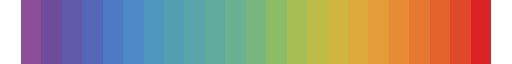

In [436]:
cell_rainbow